In [1]:
import os
import json
import time
import uuid
import hashlib
import platform
import socket
import getpass
import random
import numpy as np
import torch
from datetime import datetime, timezone
from pathlib import Path

# -------------------------------
# 0. Hard fail guard
# -------------------------------
if "CURRENT_RUN" in globals():
    raise RuntimeError(
        "CRITICAL: CURRENT_RUN already exists. "
        "Restart runtime before starting a new audit run."
    )

# -------------------------------
# 1. Time & Identity
# -------------------------------
UTC_NOW = datetime.now(timezone.utc)
RUN_TIMESTAMP = UTC_NOW.strftime("%Y%m%dT%H%M%SZ")
RUN_UUID = uuid.uuid4().hex[:8]
RUN_ID = f"srgnn_{RUN_TIMESTAMP}_{RUN_UUID}"
CURRENT_RUN = RUN_ID

# -------------------------------
# 2. Google Drive Mount
# -------------------------------
DRIVE_MOUNT = "/content/drive"
DRIVE_ROOT = f"{DRIVE_MOUNT}/MyDrive/SR-GNN_AUDIT"

try:
    from google.colab import drive
    drive.mount(DRIVE_MOUNT, force_remount=False)
except Exception as e:
    raise RuntimeError(f"FATAL: Google Drive mount failed: {e}")

# -------------------------------
# 3. Directory Structure
# -------------------------------
RUN_ROOT = Path(DRIVE_ROOT) / "runs" / RUN_ID
DIRS = {
    "root": RUN_ROOT,
    "artifacts": RUN_ROOT / "artifacts",
    "metrics": RUN_ROOT / "metrics",
    "logs": RUN_ROOT / "logs",
    "figures": RUN_ROOT / "figures",
    "configs": RUN_ROOT / "configs",
    "checks": RUN_ROOT / "checks",
    "checkpoints": RUN_ROOT / "checkpoints",
    "tmp": RUN_ROOT / "tmp",
}

for name, path in DIRS.items():
    path.mkdir(parents=True, exist_ok=False)

# -------------------------------
# 4. Environment & Seed (Patch 13)
# -------------------------------
ENV_INFO = {
    "run_id": RUN_ID,
    "utc_start_time": UTC_NOW.isoformat(),
    "hostname": socket.gethostname(),
    "user": getpass.getuser(),
    "python_version": platform.python_version(),
    "platform": platform.platform(),
    "pid": os.getpid(),
}

SEED = 1337
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

(DIRS["artifacts"] / "environment.json").write_text(json.dumps(ENV_INFO, indent=2))
(DIRS["artifacts"] / "seed.json").write_text(json.dumps({"seed": SEED}, indent=2))
print(f"[AUDIT] Environment saved. Seed fixed: {SEED}")

# -------------------------------
# 5. Audit Contract (Patch 1)
# -------------------------------
AUDIT_CONTRACT = {
    "audit_spec": "SR-GNN Audit-Oriented Technical Specification v1.2",
    "qtees_version": "v2.2",
    "sor_adaptive": False,
    "kq_trainable": False,
    "ihe_in_scope": False,
    "baseline_required": ["B0", "B1"],
    "status": "RUN_INITIALIZED",
    "notes": [
        "Only two runs are supported: B0 (baseline calibration) and B1 (regulated).",
        "No simulated evidence is allowed to drive the authoritative verdict."
    ],
}

(DIRS["artifacts"] / "audit_contract.json").write_text(json.dumps(AUDIT_CONTRACT, indent=2))
print(f"[AUDIT] Audit contract written (v1.2) for B0, B1.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[AUDIT] Environment saved. Seed fixed: 1337
[AUDIT] Audit contract written (v1.2) for B0, B1.


In [2]:
import json
import sys
import subprocess
import torch
from pathlib import Path

# --- Patch 16: Pip install audit-clean ---
def _pip_install(cmd: str):
    print(f"[AUDIT] pip: {cmd}")
    subprocess.check_call([sys.executable, "-m", "pip"] + cmd.split())

try:
    import torch_geometric
except ImportError:
    TORCH_VER = torch.__version__.split("+")[0]
    _pip_install(f"torch-geometric -f https://data.pyg.org/whl/torch-{TORCH_VER}.html")
    _pip_install(f"torch-scatter -f https://data.pyg.org/whl/torch-{TORCH_VER}.html")
    _pip_install(f"torch-sparse -f https://data.pyg.org/whl/torch-{TORCH_VER}.html")

# --- Patch 2: Sensor Contract ---
RUN_ID = RUN_ID if "RUN_ID" in globals() else "UNKNOWN_RUN"
SENSOR_CONTRACT = {
    "version": "1.2",
    "sensor_profile_id": "graph_default_v1",
    "run_id": RUN_ID,
    "sensors": {
        "loss": {"sensor_id": "S-LOSS-001", "domain": "R+", "unit": "nats"},
        "loss_variance": {"sensor_id": "S-LOSS-VAR-001", "domain": "R+", "unit": "nats^2", "window": 10, "estimator": "unbiased_sample_variance"},
        "grad_norm": {"sensor_id": "S-GRAD-NORM-001", "domain": "R+", "unit": "L2"},
        "update_ratio": {"sensor_id": "S-UPD-RATIO-001", "domain": "R+|OMITTED", "unit": "ratio", "policy": "OMIT_IF_NOT_COMPUTABLE"},
        "logits_entropy": {"sensor_id": "S-HLOGITS-001", "domain": "[0,1]", "unit": "normalized_entropy"},
        "C": {"sensor_id": "S-COHERENCE-001", "domain": "[0,1]", "unit": "cosine_clamped"},
        "H_norm": {"sensor_id": "S-HNORM-001", "domain": "[0,1]", "unit": "normalized_entropy"},
        "KQ": {"sensor_id": "S-KQ-001", "domain": "[0,1]", "unit": "normalized_quality"}
    }
}

RUN_ROOT = Path(RUN_ROOT) if "RUN_ROOT" in globals() else Path(".")
out_path = RUN_ROOT / "artifacts" / "sensor_contract.json"
out_path.write_text(json.dumps(SENSOR_CONTRACT, indent=2, sort_keys=True))
print(f"[AUDIT] Sensor contract written → {out_path}")

[AUDIT] Sensor contract written → /content/drive/MyDrive/SR-GNN_AUDIT/runs/srgnn_20251224T182721Z_75c8b21b/artifacts/sensor_contract.json


In [3]:
pip install torch-geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-$(python -c "import torch; print(torch.__version__)").htm

Looking in links: https://data.pyg.org/whl/torch-2.9.0+cpu.htm


In [4]:
# ============================================================
# Cell 02.5 — Texas Dataset & GNN Bootstrap (Real-World Data)
# QTEES v2.2 | SR-GNN Audit Spec v1.2
#
# Purpose:
#   - Load authentic Texas (WebKB) graph via torch_geometric.
#   - Initialize Graph Convolutional Network (GCN).
#   - Prepare global 'data', 'model', and 'optimizer' for audit.
# ============================================================

import torch
import torch.nn.functional as F
from torch.nn import Linear
from pathlib import Path

# --- Dependency Check & Installation Logic ---
try:
    from torch_geometric.datasets import WebKB
    from torch_geometric.nn import GCNConv
    PYG_AVAILABLE = True
except ImportError:
    PYG_AVAILABLE = False

print("[AUDIT][Cell02.5] Entering Real-World Dataset Bootstrap")
print("=" * 80)

# 1. Device Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Data Loading (Texas WebKB)
def bootstrap_texas_data():
    if not PYG_AVAILABLE:
        print("[CRITICAL] torch_geometric not found. Falling back to synthetic proxy.")
        # Minimal proxy to prevent crash if library is missing during first run
        x = torch.randn(183, 1703).to(DEVICE)
        y = torch.randint(0, 5, (183,)).to(DEVICE)
        edge_index = torch.randint(0, 183, (2, 500)).to(DEVICE)
        return type('Data', (), {'x': x, 'y': y, 'edge_index': edge_index, 'num_nodes': 183, 'num_edges': 500})(), 1703, 5

    print("[AUDIT] Fetching Real Texas Dataset (WebKB)...")
    dataset = WebKB(root='/tmp/Texas', name='Texas')
    data = dataset[0].to(DEVICE)

    print(f"[AUDIT] Dataset Loaded: {dataset.name}")
    print(f"[AUDIT] Nodes: {data.num_nodes} | Edges: {data.num_edges}")
    return data, dataset.num_node_features, dataset.num_classes

data, in_channels, out_channels = bootstrap_texas_data()

# 3. Model Architecture (GCN-Audit Version)
class TexasGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(TexasGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.classifier = Linear(hidden_channels, out_channels)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (GCNConv, Linear)):
                if hasattr(m, 'weight') and m.weight is not None:
                    torch.nn.init.kaiming_normal_(m.weight)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        embeddings = self.conv2(h, edge_index)
        embeddings = F.relu(embeddings)
        logits = self.classifier(embeddings)
        return logits, embeddings

HIDDEN_SIZE = 64
model = TexasGCN(in_channels, HIDDEN_SIZE, out_channels).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

print(f"[AUDIT] Texas GNN bootstrapped on {DEVICE} with Real Data.")
print("=" * 80)

[AUDIT][Cell02.5] Entering Real-World Dataset Bootstrap
[AUDIT] Fetching Real Texas Dataset (WebKB)...
[AUDIT] Dataset Loaded: texas
[AUDIT] Nodes: 183 | Edges: 325
[AUDIT] Texas GNN bootstrapped on cpu with Real Data.


In [5]:
import torch
import sys

print("=" * 80)
print("[AUDIT][CHECK] STARTING SYSTEM SANITY VERIFICATION")
print("-" * 80)

print(f"[VERIFY] PyTorch Version: {torch.__version__}")
print(f"[VERIFY] CUDA Available:  {torch.cuda.is_available()}")

# --- Patch 14: Dataset verification ---
print("-" * 80)
if 'data' in globals():
    try:
        print("[DATA] Texas Graph Loaded")
        print(f"[DATA] x shape:          {tuple(data.x.shape)}")
        print(f"[DATA] y shape:          {tuple(data.y.shape)}")
        print(f"[DATA] edge_index shape: {tuple(data.edge_index.shape)}")
        print(f"[DATA] num_nodes:        {data.num_nodes}")
        print(f"[DATA] num_edges:        {data.num_edges}")
        print("[RESULT] DATASET VERIFIED: SUCCESS")
    except Exception as e:
        print(f"[RESULT] DATASET INSPECTION FAILED: {e}")
else:
    print("[RESULT] data NOT FOUND. Please run Cell 02.5 first.")

if 'model' in globals():
    num_params = sum(p.numel() for p in model.parameters())
    print(f"[MODEL] Total Parameters: {num_params}")
    print("[RESULT] MODEL INITIALIZATION VERIFIED: SUCCESS")

print("=" * 80)

[AUDIT][CHECK] STARTING SYSTEM SANITY VERIFICATION
--------------------------------------------------------------------------------
[VERIFY] PyTorch Version: 2.9.0+cpu
[VERIFY] CUDA Available:  False
--------------------------------------------------------------------------------
[DATA] Texas Graph Loaded
[DATA] x shape:          (183, 1703)
[DATA] y shape:          (183,)
[DATA] edge_index shape: (2, 325)
[DATA] num_nodes:        183
[DATA] num_edges:        325
[RESULT] DATASET VERIFIED: SUCCESS
[MODEL] Total Parameters: 113541
[RESULT] MODEL INITIALIZATION VERIFIED: SUCCESS


In [6]:
# ============================================================
# Cell 02.7 — Sensor Layer & Dual-Entropy Monitoring (v1.4)
# Purpose:
#    - Implementation of KQ (Latent Quality) using two types of entropy.
#    - H_logits: Prediction uncertainty.
#    - H_latent (Coherence proxy): Embedding organization.
# ============================================================

import torch
import math
from datetime import datetime, timezone

# --- Patch 3: KQ domain clamping ---
def compute_coherence(embeddings: torch.Tensor) -> float:
    """Avg cosine similarity to centroid, clamped to [0,1] to satisfy contract."""
    if not isinstance(embeddings, torch.Tensor) or embeddings.dim() != 2:
        return 0.0
    centroid = torch.mean(embeddings, dim=0, keepdim=True)
    cos = torch.nn.functional.cosine_similarity(embeddings, centroid)
    c = float(torch.mean(cos).item())

    # Clamping logic to satisfy the [0,1] contract domain
    if c < 0.0: c = 0.0
    if c > 1.0: c = 1.0
    return c

def compute_normalized_entropy(logits: torch.Tensor) -> float:
    """Calculates normalized Shannon entropy of prediction logits [0, 1]."""
    if not isinstance(logits, torch.Tensor):
        return 1.0
    probs = torch.softmax(logits, dim=-1)
    # Shannon entropy with numerical stability epsilon
    entropy = -torch.sum(probs * torch.log(probs + 1e-9), dim=-1)

    num_classes = logits.shape[-1]
    max_entropy = math.log(max(num_classes, 2))
    return float(torch.mean(entropy / max_entropy).item())

def observe_step(step_idx: int, batch: any, out: tuple, loss_t: torch.Tensor) -> dict:
    """Captures s_t with Dual-Entropy analysis."""
    logits, emb = out

    loss_val = float(loss_t.item())
    H_logits = compute_normalized_entropy(logits)
    C = compute_coherence(emb)

    # KQ Formula: Quality = Coherence * (1.0 - Prediction Entropy)
    KQ = C * (1.0 - H_logits)

    return {
        "step": step_idx,
        "timestamp": datetime.now(timezone.utc).isoformat(),
        "loss": loss_val,
        "KQ": KQ,
        "C": C,
        "H_norm": H_logits,
        "logits_entropy": H_logits
    }

print("[AUDIT] Cell 02.7: Dual-Entropy Sensor Layer Active.")

[AUDIT] Cell 02.7: Dual-Entropy Sensor Layer Active.


In [7]:
# === Cell 03 — SR-GNN TRAIN STEP ADAPTER (TEXAS-FIX v1.7) ===
# Purpose:
#    - Final Audit Adapter for Real-World Texas Node Classification.
#    - FIX: Removed iterator logic (synthetic feel).
#    - FIX: Captures real Gradient Norms and Param Ratios from the full graph.
# ============================================================

import math
import torch
import statistics

# Audit Configuration
AUDIT_CONFIG = {
    "loss_variance_window": 10,
    "param_ratio_eps": 1e-12
}

_AUDIT_LOSS_BUF = []

def _compute_grad_norm(model):
    """Calculates the global L2 norm of gradients."""
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            total_norm += p.grad.detach().data.norm(2).item() ** 2
    return math.sqrt(total_norm)

def train_step_audit():
    """
    Standard train step bonded to Texas Data (Full Graph).
    """
    model.train()
    optimizer.zero_grad()

    # Capture state BEFORE
    params_before = torch.cat([p.view(-1) for p in model.parameters()]).detach().clone()
    theta_norm = params_before.norm(2).item()

    # Model Execution (Full Graph Mode)
    logits, emb = model(data.x, data.edge_index)
    loss = torch.nn.functional.cross_entropy(logits, data.y)

    # Patch 15: Accuracy calculation added for audit validity
    pred = logits.argmax(dim=-1)
    acc = float((pred == data.y).float().mean().item())

    loss.backward()

    # Gradient Capture
    g_norm = _compute_grad_norm(model)
    optimizer.step()

    # Capture state AFTER
    params_after = torch.cat([p.view(-1) for p in model.parameters()]).detach()
    delta_theta_norm = (params_after - params_before).norm(2).item()

    # Patch 4: Using unified 'update_ratio' key
    update_ratio = delta_theta_norm / (theta_norm + AUDIT_CONFIG["param_ratio_eps"])

    # Variance Logic
    l_val = loss.item()
    _AUDIT_LOSS_BUF.append(l_val)
    if len(_AUDIT_LOSS_BUF) > AUDIT_CONFIG["loss_variance_window"]:
        _AUDIT_LOSS_BUF.pop(0)
    l_var = statistics.variance(_AUDIT_LOSS_BUF) if len(_AUDIT_LOSS_BUF) > 1 else 0.0

    # Patch 4 & 15: Returning unified keys and accuracy
    return {
        "loss": loss,
        "loss_val": l_val,
        "loss_variance": l_var,
        "grad_norm": g_norm,
        "update_ratio": update_ratio,
        "accuracy": acc,
        "logits": logits.detach(),
        "emb": emb.detach()
    }

print("[AUDIT] Adapter v1.7 initialized. Linked to Real Texas Node Classification.")

[AUDIT] Adapter v1.7 initialized. Linked to Real Texas Node Classification.


In [8]:
import json
from pathlib import Path

print("[AUDIT][Cell03.5] Starting Authentic Baseline Logging (B0)")

def safe_mean(data_list):
    valid_data = [float(x) for x in data_list if x is not None]
    return sum(valid_data) / len(valid_data) if valid_data else 0.0

NUM_B0_RUNS = 5
STEPS_PER_B0 = 15
baseline_catalog = []

for run_idx in range(NUM_B0_RUNS):
    run_id = f"B0_RUN_{run_idx:02d}"
    # Patch 5: Logging mean stats
    acc = {"loss": [], "loss_variance": [], "grad_norm": [], "KQ": [], "update_ratio": []}

    for step_idx in range(STEPS_PER_B0):
        out = train_step_audit()
        obs = observe_step(step_idx, None, (out["logits"], out["emb"]), out["loss"])

        acc["loss"].append(out["loss_val"])
        acc["loss_variance"].append(out["loss_variance"])
        acc["grad_norm"].append(out["grad_norm"])
        acc["update_ratio"].append(out["update_ratio"])
        acc["KQ"].append(obs.get("KQ", 0.0))

    b0_log = {
        "run": run_id,
        "steps": len(acc["loss"]),
        "loss_mean": safe_mean(acc["loss"]),
        "loss_variance_mean": safe_mean(acc["loss_variance"]),
        "grad_norm_mean": safe_mean(acc["grad_norm"]),
        "update_ratio_mean": safe_mean(acc["update_ratio"]),
        "KQ_mean": safe_mean(acc["KQ"]),
    }
    baseline_catalog.append(b0_log)
    print(f"{run_id:<12} | Loss: {b0_log['loss_mean']:.4f} | Δθ/θ: {b0_log['update_ratio_mean']:.6f} | SAVED")

(Path(RUN_ROOT) / "logs" / "b0_runs.json").write_text(json.dumps(baseline_catalog, indent=2))

[AUDIT][Cell03.5] Starting Authentic Baseline Logging (B0)
B0_RUN_00    | Loss: 1.0026 | Δθ/θ: 0.106402 | SAVED
B0_RUN_01    | Loss: 0.6736 | Δθ/θ: 0.042110 | SAVED
B0_RUN_02    | Loss: 0.5639 | Δθ/θ: 0.033852 | SAVED
B0_RUN_03    | Loss: 0.4201 | Δθ/θ: 0.027935 | SAVED
B0_RUN_04    | Loss: 0.3725 | Δθ/θ: 0.027850 | SAVED


1295

In [9]:
# ============================================================
# [AUDIT][Cell04] CALIBRATION INTEGRITY GATE (A) — v1.5
# Author: Artem Brezgin, Spanda Foundation (C) 2025
#
# Purpose:
#    - Analyze baseline evidence (B0) to establish the SOR.
#    - FIX: Implement SAFETY_FLOOR to prevent 0.0 epsilons (Audit Trap).
#    - Patch 6: Synchronized with mean-based metrics from B0.
# ============================================================

import json
import statistics
from pathlib import Path
from datetime import datetime, timezone

print("[AUDIT][Cell04] Entering CALIBRATION INTEGRITY GATE (A)")
print("=" * 80)

# ------------------------------------------------------------
# 0. Context & Artifact Verification
# ------------------------------------------------------------
try:
    if 'RUN_ROOT' in globals():
        RUN_ROOT_PATH = Path(RUN_ROOT)
    else:
        raise RuntimeError("Audit context missing.")

    LOGS = RUN_ROOT_PATH / "logs"
    ART = RUN_ROOT_PATH / "artifacts"
    ART.mkdir(parents=True, exist_ok=True)
except NameError:
    raise RuntimeError("Context missing. Ensure Cell 01 was executed.")

# ------------------------------------------------------------
# 1. Load Baseline Evidence (B0)
# ------------------------------------------------------------
b0_json = LOGS / "b0_runs.json"
if not b0_json.exists():
    raise RuntimeError("[AUDIT] Missing b0_runs.json. Run Cell 03.5 first.")

b0_runs = json.loads(b0_json.read_text())

# ------------------------------------------------------------
# 2. Data Filtering & Mapping (Applied Patch 6)
# ------------------------------------------------------------
def get_mad(xs):
    """Calculates Median Absolute Deviation."""
    if not xs: return 0.0
    med = statistics.median(xs)
    return statistics.median([abs(x - med) for x in xs])

# Patch 6: Reading *_mean keys to align with B0 log structure
metrics_map = {
    "loss_variance": [float(r.get("loss_variance_mean", 0.0)) for r in b0_runs],
    "grad_norm": [float(r.get("grad_norm_mean", 0.0)) for r in b0_runs],
    "update_ratio": [float(r.get("update_ratio_mean", 0.0)) for r in b0_runs],
}

# ------------------------------------------------------------
# 3. SOR Boundary Calculation with Safety Floor
# ------------------------------------------------------------
# Audit Policy: Never allow an epsilon of 0.0 unless the metric is intentionally disabled.
# This prevents "False Positives" in governance triggers.
SAFETY_FLOORS = {
    "loss_variance": 1e-6,
    "grad_norm": 1e-4,
    "update_ratio": 1e-5
}

bounds = {}
print("-" * 80)
print(f"{'METRIC':<15} | {'MEDIAN':<10} | {'MAD':<10} | {'EPSILON (Limit)'}")
print("-" * 80)

for m_name, values in metrics_map.items():
    if not values:
        bounds[m_name] = None
        continue

    med = statistics.median(values)
    m_mad = get_mad(values)

    # Epsilon = Median + 3*MAD
    epsilon_raw = med + (3 * m_mad) if m_mad > 0 else med * 1.5

    # Apply Safety Floor (FIX: Prevent 0.0 Epsilon)
    floor = SAFETY_FLOORS.get(m_name, 1e-7)
    epsilon = max(epsilon_raw, floor)

    bounds[m_name] = {
        "median": med,
        "mad": m_mad,
        "epsilon": epsilon,
        "is_floored": epsilon == floor
    }

    status_note = " (FLOORED)" if epsilon == floor else ""
    print(f"{m_name:<15} | {med:<10.6f} | {m_mad:<10.6f} | {epsilon:.6f}{status_note}")

# ------------------------------------------------------------
# 4. Freeze SOR
# ------------------------------------------------------------
SOR = {
    "status": "CALIBRATION_FROZEN",
    "timestamp": datetime.now(timezone.utc).isoformat(),
    "method": "median + 3*MAD + safety_floor",
    "bounds": bounds
}

(ART / "sor_bounds.json").write_text(json.dumps(SOR, indent=2))

print("-" * 80)
print(f"[AUDIT] Calibration SUCCESSFUL. SOR frozen with Safety Floors.")
print("=" * 80)

[AUDIT][Cell04] Entering CALIBRATION INTEGRITY GATE (A)
--------------------------------------------------------------------------------
METRIC          | MEDIAN     | MAD        | EPSILON (Limit)
--------------------------------------------------------------------------------
loss_variance   | 0.003450   | 0.001209   | 0.007077
grad_norm       | 1.094657   | 0.260354   | 1.875717
update_ratio    | 0.033852   | 0.006003   | 0.051860
--------------------------------------------------------------------------------
[AUDIT] Calibration SUCCESSFUL. SOR frozen with Safety Floors.


In [10]:
# ============================================================
# Cell 05 — Control Policy Skeleton (B1) - PATCHED v1.7
# QTEES v2.2 | SR-GNN Audit Spec v1.2
#
# Purpose:
#    - Define deterministic governance hooks for B1 regulated run.
#    - FIX: Dynamic calculation of EVD ceiling based on B0 metadata.
#    - REMOVED: Hardcoded 0.30 ceiling to ensure data-driven audit.
#    - Maintain full audit traceability and EVD calibration.
# ============================================================

import json
import hashlib
import statistics
from pathlib import Path
from datetime import datetime, timezone

print("[AUDIT][Cell05] Entering control policy skeleton (B1)")
print("=" * 80)

# ------------------------------------------------------------
# 0. Context & Path Resolution
# ------------------------------------------------------------
try:
    if 'RUN_ROOT' in globals():
        RUN_ROOT_PATH = Path(RUN_ROOT)
    elif 'CURRENT_RUN' in globals():
        RUN_ROOT_PATH = Path("/content/drive/MyDrive/SR-GNN_AUDIT/runs") / CURRENT_RUN
    else:
        raise RuntimeError("Context missing. Run Cell 01 first.")
except NameError:
    raise RuntimeError("Context missing.")

ARTIFACTS = RUN_ROOT_PATH / "artifacts"
LOGS = RUN_ROOT_PATH / "logs"

# ------------------------------------------------------------
# 1. Load Calibration Metadata & Dynamic EVD Calculation
# ------------------------------------------------------------
b0_runs_path = LOGS / "b0_runs.json"
if not b0_runs_path.exists():
    raise RuntimeError("[Cell05] Missing b0_runs.json — run Cell 03.5 first")

b0_runs = json.loads(b0_runs_path.read_text())
SOR_DATA = json.loads((ARTIFACTS / "sor_bounds.json").read_text())
SOR_HASH = hashlib.sha256(json.dumps(SOR_DATA, sort_keys=True).encode()).hexdigest()

# Extract loss variance from baseline for EVD ceiling calculation
evd_values = [float(r.get("loss_variance_mean", 0)) for r in b0_runs]

# Statistical derivation of the Governance Ceiling
med_evd = statistics.median(evd_values)
mad_evd = statistics.median([abs(x - med_evd) for x in evd_values])

# Authoritative Calculation: Ceiling = Median + 3*MAD
# This ensures the ceiling is sensitive to the specific baseline distribution
EVD_DYNAMIC_CEILING = med_evd + (3 * mad_evd if mad_evd > 0 else med_evd * 0.5)

# ------------------------------------------------------------
# 2. Formalized Policy Specification (B1 Regulated)
# ------------------------------------------------------------
POLICY = {
    "policy_id": "B1_Regulated_Policy_v1.7",
    "regime_note": "B1 regulated training on real Texas graph (Dynamic EVD)",
    "sor_hash": SOR_HASH,
    "governance_parameters": {
        "cooldown_steps": 5,
        "min_lr_multiplier": 1e-6,
        "variance_window_size": 10,
        "variance_estimator": "unbiased_sample_variance",
        "evd_governance_ceiling": round(EVD_DYNAMIC_CEILING, 6) # Using calculated value
    },
    "levels": {
        "L1": {"action": "lr_scale_down", "lr_factor": 0.5, "max_consecutive_violation_steps": 3, "note": "Mild stabilization"},
        "L2": {"action": "lr_scale_down", "lr_factor": 0.2, "max_consecutive_violation_steps": 6, "note": "Aggressive stabilization"},
        "L3": {"action": "abort_training", "lr_factor": 0.0, "max_consecutive_violation_steps": 10, "note": "Abort if sustained instability"}
    }
}

(ARTIFACTS / "policy_spec.json").write_text(json.dumps(POLICY, indent=2))

# ------------------------------------------------------------
# 3. Authoritative Thresholds (Data-Driven)
# ------------------------------------------------------------
# This file serves as authoritative evidence for auditors.
thresholds = {
    "EVD": {
        "ceiling": POLICY["governance_parameters"]["evd_governance_ceiling"],
        "calculation_method": "median + 3*MAD from B0 distribution",
        "source": "SR-GNN Dynamic Calibration Engine",
        "note": "Threshold is derived from baseline evidence, not hardcoded."
    },
    "SOR_BOUNDARIES": SOR_DATA["bounds"]
}
(ARTIFACTS / "thresholds.json").write_text(json.dumps(thresholds, indent=2))

print(f"[AUDIT] Policy v1.7 written with Dynamic EVD Ceiling: {POLICY['governance_parameters']['evd_governance_ceiling']}")
print(f"[AUDIT] Baseline Median: {med_evd:.6f} | MAD: {mad_evd:.6f}")
print(f"[AUDIT] Cooldown Rule: {POLICY['governance_parameters']['cooldown_steps']} steps.")
print("=" * 80)

[AUDIT][Cell05] Entering control policy skeleton (B1)
[AUDIT] Policy v1.7 written with Dynamic EVD Ceiling: 0.007077
[AUDIT] Baseline Median: 0.003450 | MAD: 0.001209
[AUDIT] Cooldown Rule: 5 steps.


In [11]:
# ============================================================
# Cell 06 — Regulated Training Loop (B1) - TEXAS-BONDED v1.8
# Author: Artem Brezgin, Spanda Foundation (C) 2025
#
# Purpose:
#    - Real-time governance on REAL Texas graph data (B1 Run).
#    - Patch 8: Integrated Real RT basis + Policy Levels (L1/L2/L3).
#    - Patch 15: Added accuracy monitoring in regulated loop.
#    - FIX: Real "consecutive violation" tracking & training abort.
# ============================================================

import json
import torch
from pathlib import Path

print("[AUDIT][Cell06] Entering B1 regulated loop on REAL TEXAS GRAPH (AUDIT-READY)")
print("=" * 95)

# ------------------------------------------------------------
# 0. Context & Artifact Resolution
# ------------------------------------------------------------
ART = RUN_ROOT / "artifacts"
METRICS_DIR = RUN_ROOT / "metrics"

SOR = json.loads((ART / "sor_bounds.json").read_text())
POLICY = json.loads((ART / "policy_spec.json").read_text())

BOUNDS = SOR["bounds"]
LEVELS = POLICY["levels"]
GP = POLICY["governance_parameters"]

# ------------------------------------------------------------
# 1. Governance State Initialization
# ------------------------------------------------------------
COOLDOWN = int(GP["cooldown_steps"])
ORIG_LR = optimizer.param_groups[0]["lr"]
NUM_STEPS = 200  # audit-friendly horizon

CURRENT_LR_MULT = 1.0
last_intervention = -COOLDOWN
STEP_METRICS = []

# Consecutive violation counter per metric (real RT basis)
consec = {k: 0 for k in BOUNDS.keys()}
abort_triggered = False

# ------------------------------------------------------------
# 2. Policy Helper Functions
# ------------------------------------------------------------
def _violating_metrics(obs, bounds):
    """Identifies which sensors currently exceed SOR thresholds."""
    out = []
    for m, b in bounds.items():
        if not b or "epsilon" not in b:
            continue
        if m not in obs:
            continue
        try:
            if float(obs[m]) > float(b["epsilon"]):
                out.append(m)
        except Exception:
            continue
    return out

def _policy_level_from_consec(max_consec: int):
    """Maps maximum consecutive violations to policy levels (L1/L2/L3)."""
    # Map by thresholds in policy_spec (L1 < L2 < L3 severity)
    if max_consec <= LEVELS["L1"]["max_consecutive_violation_steps"]:
        return "L1"
    if max_consec <= LEVELS["L2"]["max_consecutive_violation_steps"]:
        return "L2"
    return "L3"

# ------------------------------------------------------------
# 3. Main Regulated Training Loop
# ------------------------------------------------------------
print(f"{'STEP':<4} | {'LOSS':<8} | {'GN':<8} | {'UPD':<10} | {'LR_MULT':<10} | {'VIOL (MAX)':<18} | STATUS")
print("-" * 95)

for step in range(NUM_STEPS):
    if abort_triggered:
        break

    # 1. Authentic Execution (Patch 15 includes accuracy)
    out = train_step_audit()

    # 2. Sensor Observation & Metric Update
    obs = observe_step(step, None, (out["logits"], out["emb"]), out["loss"])
    obs.update({
        "loss_variance": out["loss_variance"],
        "grad_norm": out["grad_norm"],
        "update_ratio": out["update_ratio"],
        "accuracy": out["accuracy"]  # Patch 15
    })

    # 3. Governance Analysis
    viol = _violating_metrics(obs, BOUNDS)

    # Update consecutive counters (Real RT tracking)
    for m in consec:
        if m in viol:
            consec[m] += 1
        else:
            consec[m] = 0

    max_consec = max(consec.values()) if consec else 0
    worst_metric = max(consec, key=lambda k: consec[k]) if any(consec.values()) else None

    status = "OK"
    applied_level = ""

    # 4. Intervention Logic (Cooldown Guarded)
    if viol and (step - last_intervention) >= COOLDOWN:
        applied_level = _policy_level_from_consec(max_consec)
        cfg = LEVELS[applied_level]
        status = f"V->{applied_level}"

        if cfg["action"] == "abort_training":
            abort_triggered = True
            status = "ABORT(L3)"
        else:
            factor = float(cfg["lr_factor"])
            CURRENT_LR_MULT *= factor
            # Safety floor from Governance Parameters
            if CURRENT_LR_MULT < float(GP["min_lr_multiplier"]):
                CURRENT_LR_MULT = float(GP["min_lr_multiplier"])

            # Apply to Optimizer
            for g in optimizer.param_groups:
                g["lr"] = ORIG_LR * CURRENT_LR_MULT

        last_intervention = step

    elif (step - last_intervention) < COOLDOWN and viol:
        status = "COOLDOWN"

    # 5. Step Reporting
    viol_str = f"{(worst_metric + ':' + str(max_consec)) if worst_metric else '-'}"
    print(f"{step:03d}  | {float(obs['loss']):<8.4f} | {float(obs['grad_norm']):<8.4f} | "
          f"{float(obs['update_ratio']):<10.6f} | {CURRENT_LR_MULT:<10.2e} | "
          f"{viol_str:<18} | {status}")

    # 6. Persistence (Audit Evidence)
    rec = {k: (v.item() if torch.is_tensor(v) else v) for k, v in obs.items() if k not in ["logits", "emb"]}
    rec.update({
        "step": step,
        "lr_mult": CURRENT_LR_MULT,
        "status": status,
        "violating_metrics": viol,
        "max_consecutive_violation": max_consec,
        "worst_metric": worst_metric,
        "level": applied_level
    })
    STEP_METRICS.append(rec)

# ------------------------------------------------------------
# 4. Finalization
# ------------------------------------------------------------
(METRICS_DIR / "regulated_run_metrics.json").write_text(json.dumps(STEP_METRICS, indent=2))
print("-" * 95)
print(f"[AUDIT] B1 regulated run done. steps={len(STEP_METRICS)} abort_triggered={abort_triggered}")
print("=" * 95)

[AUDIT][Cell06] Entering B1 regulated loop on REAL TEXAS GRAPH (AUDIT-READY)
STEP | LOSS     | GN       | UPD        | LR_MULT    | VIOL (MAX)         | STATUS
-----------------------------------------------------------------------------------------------
000  | 0.3818   | 0.8599   | 0.029783   | 1.00e+00   | -                  | OK
001  | 0.4547   | 1.0509   | 0.031530   | 1.00e+00   | -                  | OK
002  | 0.4051   | 1.4203   | 0.030270   | 1.00e+00   | -                  | OK
003  | 0.3530   | 0.7409   | 0.031098   | 1.00e+00   | -                  | OK
004  | 0.3469   | 0.7542   | 0.030848   | 1.00e+00   | -                  | OK
005  | 0.3280   | 0.9815   | 0.030529   | 1.00e+00   | -                  | OK
006  | 0.3105   | 0.7448   | 0.029656   | 1.00e+00   | -                  | OK
007  | 0.3981   | 1.6242   | 0.031130   | 1.00e+00   | -                  | OK
008  | 0.3016   | 0.6937   | 0.029109   | 1.00e+00   | -                  | OK
009  | 0.3111   | 0.8233   | 0.02

In [12]:
# ============================================================
# [AUDIT][Cell09] Authoritative Verdict from REAL B1 metrics (NO SIMULATION)
# Author: Artem Brezgin, Spanda Foundation (C) 2025
#
# Purpose:
#    - Aggregate real B1 regulated metrics into a statistical verdict.
#    - FIX: Removed hardcoded evd_ceiling=0.30.
#    - SYNC: Now uses POLICY["governance_parameters"]["evd_governance_ceiling"].
# ============================================================

import json
import numpy as np
from pathlib import Path
from datetime import datetime, timezone

print("[AUDIT][Cell09] Authoritative Verdict from REAL B1 metrics (DYNAMIC CEILING)")
print("=" * 90)

# ------------------------------------------------------------
# 0. Context & Artifact Resolution
# ------------------------------------------------------------
RUN_ROOT_PATH = Path(RUN_ROOT) if 'RUN_ROOT' in globals() else Path(".")
ART = RUN_ROOT_PATH / "artifacts"
METRICS_DIR = RUN_ROOT_PATH / "metrics"

# Load Authoritative Policy to get dynamic EVD ceiling (Audit Remark Fix)
policy_path = ART / "policy_spec.json"
if not policy_path.exists():
    raise RuntimeError("[AUDIT][Cell09] Missing policy_spec.json. Run Cell 05 first.")

POLICY = json.loads(policy_path.read_text())
# Dynamic Ceiling synchronized with Cell 05/06
EVD_CEILING_DYNAMIC = float(POLICY["governance_parameters"]["evd_governance_ceiling"])

# Load B1 metrics
m_path = METRICS_DIR / "regulated_run_metrics.json"
if not m_path.exists():
    raise RuntimeError("[AUDIT][Cell09] Missing regulated_run_metrics.json. Run Cell 06 (B1) first.")

metrics = json.loads(m_path.read_text())
if not metrics:
    raise RuntimeError("[AUDIT][Cell09] Empty B1 metrics file.")

# ------------------------------------------------------------
# 1. Helper: Violation Identification
# ------------------------------------------------------------
def _is_violation(rec):
    """Checks if a metric record indicates a violation state."""
    viol = rec.get("violating_metrics", [])
    return len(viol) > 0

# ------------------------------------------------------------
# 2. Compute Violation Segments and RT (Recovery Time)
# ------------------------------------------------------------
events = []
in_event = False
start = None
rt = 0

for i, rec in enumerate(metrics):
    v = _is_violation(rec)
    if v and not in_event:
        in_event = True
        start = i
        rt = 1
    elif v and in_event:
        rt += 1
    elif (not v) and in_event:
        # Close event
        events.append({"start_step": start, "end_step": i-1, "RT": rt})
        in_event = False
        start = None
        rt = 0

# If run ends while still violating -> open event (Unrecovered state)
open_event = None
if in_event:
    open_event = {"start_step": start, "end_step": metrics[-1]["step"], "RT": rt}

closed_rts = [e["RT"] for e in events]
open_events = 1 if open_event else 0
closed_events = len(events)
total_events = closed_events + open_events

# ------------------------------------------------------------
# 3. Cybernetic Metrics Calculation
# ------------------------------------------------------------
# EVD (Evidence Density) = fraction of violating steps / all steps
viol_steps = sum(1 for r in metrics if _is_violation(r))
total_steps = len(metrics)
EVD = viol_steps / total_steps if total_steps else 0.0

# Recovery Time Statistics
if closed_rts:
    RT_stats = {
        "RT_min": int(np.min(closed_rts)),
        "RT_median": float(np.median(closed_rts)),
        "RT_p95": float(np.percentile(closed_rts, 95)),
        "RT_max": int(np.max(closed_rts)),
    }
else:
    RT_stats = {"RT_min": 0, "RT_median": 0.0, "RT_p95": 0.0, "RT_max": 0}

# Abort signal: true if an open event exists OR any step status is ABORT(L3)
abort_by_open = open_event is not None
abort_by_status = any(str(r.get("status", "")).startswith("ABORT") for r in metrics)
Abort = bool(abort_by_open or abort_by_status)

# ------------------------------------------------------------
# 4. Final Verdict Policy (Dynamic & Synchronized)
# ------------------------------------------------------------
# PASS conditions:
# - If Abort was triggered: it's a successful governance action.
# - EVD must not exceed the DYNAMIC governance ceiling from policy.
if Abort:
    FINAL_VERDICT = "PASS"
else:
    FINAL_VERDICT = "PASS" if EVD <= EVD_CEILING_DYNAMIC else "FAIL"

# ------------------------------------------------------------
# 5. Persist Authoritative Verdict
# ------------------------------------------------------------
CELL09_VERDICT = {
    "run_id": RUN_ROOT_PATH.name,
    "generated_utc": datetime.now(timezone.utc).isoformat(),
    "evidence_source": "regulated_run_metrics.json (REAL B1)",
    "cybernetic_metrics": {
        "EVD": round(float(EVD), 6),
        "ABORT_SIGNAL": Abort,
        "RECOVERY_COMPLETE": open_events == 0,
        "VIOLATION_STEPS": int(viol_steps),
        "TOTAL_STEPS": int(total_steps),
        "EVD_CEILING": EVD_CEILING_DYNAMIC  # Synchronized with Policy
    },
    "RT_stats": RT_stats,
    "RT_events_total": int(total_events),
    "RT_events_closed": int(closed_events),
    "RT_events_open": int(open_events),
    "open_event": open_event,
    "closed_events": events[:50],
    "final_verdict": FINAL_VERDICT
}

out_path = RUN_ROOT_PATH / "logs" / "cell09_audit_verdict.json"
out_path.write_text(json.dumps(CELL09_VERDICT, indent=2))

print(f"[AUDIT] Evidence: steps={total_steps}, violations={viol_steps}")
print(f"[AUDIT] Dynamic Ceiling Sync: {EVD_CEILING_DYNAMIC:.4f}")
print(f"[AUDIT] EVD={EVD:.4f} | Abort={Abort} | Verdict={FINAL_VERDICT}")
print("=" * 90)

[AUDIT][Cell09] Authoritative Verdict from REAL B1 metrics (DYNAMIC CEILING)
[AUDIT] Evidence: steps=200, violations=1
[AUDIT] Dynamic Ceiling Sync: 0.0071
[AUDIT] EVD=0.0050 | Abort=False | Verdict=PASS


In [13]:
# ============================================================
# Cell 11 — Human-Readable Event Report (ULTRA-MASTER v2.8)
# Author: Artem Brezgin, Spanda Foundation (C) 2025
#
# Purpose:
#    - Full Synthesis: Executive Summary + Training Dynamics + Tech Evidence.
#    - Restoration of v2.5 depth: Tables, detailed RT stats, and ranges.
#    - Patch 11 Compatibility: Clean audit trail (B0/B1 only, no simulations).
#    - Remark 4 FIX: Synchronized EVD ceiling display with thresholds.json.
# ============================================================

import json
import math
from pathlib import Path
from datetime import datetime, timezone

def audit_require(val, name):
    """STRICT GUARD: Ensures critical audit fields are present."""
    if val is None:
        raise RuntimeError(f"[AUDIT][Cell11] Mandatory field '{name}' missing. Integrity compromised.")
    return val

def _fmt(val, decimals=4):
    """Standardized audit formatting for numbers."""
    if val is None or val == "OMITTED":
        return "OMITTED"
    try:
        return f"{float(val):.{decimals}f}"
    except (ValueError, TypeError):
        return "N/A"

def _load_json(path):
    """Safe JSON loader for artifacts."""
    if path.exists():
        try: return json.loads(path.read_text())
        except: return None
    return None

def get_dynamics_stats(metrics, key):
    """Computes mean, min, and max for a given metric key."""
    if not metrics: return 0.0, 0.0, 0.0
    vals = [float(m[key]) for m in metrics if m.get(key) is not None]
    if not vals: return 0.0, 0.0, 0.0
    return sum(vals)/len(vals), min(vals), max(vals)

print("\n" + "!"*95)
print("[AUDIT][Cell11] GENERATING COMPREHENSIVE MASTER AUDIT SYNTHESIS (v2.8)")
print("!"*95)

# ------------------------------------------------------------
# 0. Context Resolution
# ------------------------------------------------------------
try:
    if 'RUN_ROOT' in globals():
        RUN_ROOT_PATH = Path(RUN_ROOT)
    else:
        # Emergency path resolution
        RUN_ROOT_PATH = Path("/content/drive/MyDrive/SR-GNN_AUDIT/runs")
    LOGS = RUN_ROOT_PATH / "logs"
    ART = RUN_ROOT_PATH / "artifacts"
    METRICS_DIR = RUN_ROOT_PATH / "metrics"
except NameError:
    raise RuntimeError("Context missing. Ensure Cell 01 was executed.")

# ------------------------------------------------------------
# 1. Artifact Synthesis (Applied Patch 11: Real evidence only)
# ------------------------------------------------------------
sor = _load_json(ART / "sor_bounds.json")
b0_runs = _load_json(LOGS / "b0_runs.json")
verdict = _load_json(LOGS / "cell09_audit_verdict.json")
thresholds = _load_json(ART / "thresholds.json")
reg_metrics = _load_json(METRICS_DIR / "regulated_run_metrics.json") or []

print(f"RUN_ID:        {RUN_ROOT_PATH.name}")
print(f"GENERATED AT:  {datetime.now(timezone.utc).isoformat()}")
print("=" * 95)

# ============================================================
# PART A: EXECUTIVE SUMMARY
# ============================================================
print("\n[PART A] EXECUTIVE SUMMARY (AUDIT-SAFE)")

# 1. Numerical Stability (SOR)
print("\n================================================================================")
print(" SECTION 1: NUMERICAL STABILITY OPERATING REGION (SOR)")
print("================================================================================")
if sor:
    print(f"Calibration Source: B0 baseline calibration")
    bounds = sor.get("bounds", {})
    for m in ["loss_variance", "grad_norm", "update_ratio"]:
        b = bounds.get(m)
        if b: print(f"  - {m:<15} : Median={_fmt(b.get('median'))} | EPS={_fmt(b.get('epsilon'))}")
    print("\nNote: Boundaries derived from Texas GNN baseline distribution.")
else:
    print("  [!] SOR artifacts missing.")

# 2. Observed Training Dynamics (B1 Run)
print("\n================================================================================")
print(" SECTION 2: OBSERVED TRAINING DYNAMICS (REAL B1 RUN)")
print("================================================================================")
if reg_metrics:
    m_acc, min_acc, max_acc = get_dynamics_stats(reg_metrics, "accuracy")
    m_kq, min_kq, max_kq = get_dynamics_stats(reg_metrics, "KQ")
    m_gn, min_gn, max_gn = get_dynamics_stats(reg_metrics, "grad_norm")
    m_loss, min_loss, max_loss = get_dynamics_stats(reg_metrics, "loss")

    print(f"  - Accuracy          : Mean={_fmt(m_acc)} | Range=[{_fmt(min_acc)}, {_fmt(max_acc)}]")
    print(f"  - KQ (Quality)      : Mean={_fmt(m_kq)} | Range=[{_fmt(min_kq)}, {_fmt(max_kq)}]")
    print(f"  - Grad Norm         : Mean={_fmt(m_gn)} | Range=[{_fmt(min_gn)}, {_fmt(max_gn)}]")
    print(f"  - Task Loss         : Mean={_fmt(m_loss)} | Range=[{_fmt(min_loss)}, {_fmt(max_loss)}]")
    print(f"  - Steps Logged:     {len(reg_metrics)}")
else:
    print("  [!] No regulated run metrics found.")

# 3. Event Governance & Resilience (Authoritative)
print("\n================================================================================")
print(" SECTION 3: EVENT GOVERNANCE & RESILIENCE (B1 REAL EVIDENCE)")
print("================================================================================")
if verdict:
    RT = verdict.get("RT_stats", {})
    cyb = verdict.get("cybernetic_metrics", {})

    # Synchronize EVD ceiling with thresholds.json (Remark 4)
    evd_ceil = thresholds["EVD"]["ceiling"] if thresholds else cyb.get('EVD_CEILING', 0.3)

    print(f"  RT events total      : {verdict.get('RT_events_total')}")
    print(f"  RT events closed     : {verdict.get('RT_events_closed')}")
    print(f"  RT events open       : {verdict.get('RT_events_open')}")
    print("-" * 40)
    print(f"  RT_min               : {RT.get('RT_min', 0)} steps")
    print(f"  RT_median            : {RT.get('RT_median', 0)} steps")
    print(f"  RT_p95               : {math.ceil(RT.get('RT_p95', 0))} steps (Ceil-rounded)")
    print(f"  RT_max               : {RT.get('RT_max', 0)} steps")
    print("-" * 40)
    print(f"  Violation Density(EVD): {_fmt(cyb.get('EVD'))} (Ceiling: {_fmt(evd_ceil)})")
    print(f"  Abort signal         : {cyb.get('ABORT_SIGNAL')}")
else:
    print("  [!] Authoritative Verdict missing.")

# 4. Final Verdict
print("\n================================================================================")
print(" FINAL AUTHORITATIVE AUDIT VERDICT")
print("================================================================================")
if verdict:
    f_verdict = verdict.get('final_verdict', 'FAIL')
    print(f" STATUS: {f_verdict}")
    print("\nCONCLUSION: The system demonstrated resilient behavior across the regulated B1 run.")
    print("Interventions were correctly triggered by SOR thresholds and recorded.")
    print("Audit integrity based on REAL B1 evidence: PASSED.")
else:
    print(" STATUS: INCOMPLETE")

# ============================================================
# PART B: DEEP TECHNICAL EVIDENCE
# ============================================================
print("\n\n" + "=" * 95)
print("[PART B] DEEP TECHNICAL EVIDENCE (FULL CATALOG)")
print("=" * 95)

# B.2 Baseline Catalog
print("\n[B.2] BASELINE EVIDENCE (B0 RUNS) CATALOG")
if b0_runs:
    print(f"{'RUN_ID':<15} | {'STEPS':<6} | {'LOSS (avg)':<10} | {'UPD_RATIO (mean)':<16} | {'KQ (avg)':<8}")
    print("-" * 75)
    for r in b0_runs:
        upd = r.get('update_ratio_mean', 'OMITTED')
        upd_s = f"{upd:.6f}" if isinstance(upd, (float, int)) else str(upd)
        print(f"{r.get('run'):<15} | {r.get('steps'):<6} | {_fmt(r.get('loss_mean')):<10} | {upd_s:<16} | {_fmt(r.get('KQ_mean')):<8}")

# B.3 Intervention Chronology (Real-time from B1)
print("\n[B.3] B1 INTERVENTION CHRONOLOGY (REAL-TIME)")
if reg_metrics:
    # Filter for steps where status is not 'OK' or 'COOLDOWN'
    interventions = [m for m in reg_metrics if m.get("status") not in ["OK", "COOLDOWN", "NONE"]]
    if interventions:
        print(f"{'STEP':<6} | {'STATUS':<12} | {'LEVEL':<6} | {'VIOLATING METRICS':<25}")
        print("-" * 70)
        for m in interventions:
            viol_list = ",".join(m.get("violating_metrics", []))
            print(f"{m.get('step'):<6} | {m.get('status'):<12} | {m.get('level', 'N/A'):<6} | {viol_list:<25}")
    else:
        print("No governance interventions were required during the regulated run.")

print("\n" + "="*95)
print("[AUDIT][Cell11] MASTER SYNTHESIS v2.8 COMPLETED")
print("="*95)


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[AUDIT][Cell11] GENERATING COMPREHENSIVE MASTER AUDIT SYNTHESIS (v2.8)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
RUN_ID:        srgnn_20251224T182721Z_75c8b21b
GENERATED AT:  2025-12-24T18:27:30.543624+00:00

[PART A] EXECUTIVE SUMMARY (AUDIT-SAFE)

 SECTION 1: NUMERICAL STABILITY OPERATING REGION (SOR)
Calibration Source: B0 baseline calibration
  - loss_variance   : Median=0.0034 | EPS=0.0071
  - grad_norm       : Median=1.0947 | EPS=1.8757
  - update_ratio    : Median=0.0339 | EPS=0.0519

Note: Boundaries derived from Texas GNN baseline distribution.

 SECTION 2: OBSERVED TRAINING DYNAMICS (REAL B1 RUN)
  - Accuracy          : Mean=0.9119 | Range=[0.8361, 0.9508]
  - KQ (Quality)      : Mean=0.6516 | Range=[0.5218, 0.7196]
  - Grad Norm         : Mean=0.6913 | Range=[0.2697, 2.0418]
  - Task Loss         : Mean=0.2361 | Range=[0.1392,

In [14]:
# ============================================================
# Cell 15 — Comparative Analysis (Baseline vs Regulated) - FIXED
# Author: Artem Brezgin, Spanda Foundation (C) 2025
#
# Purpose:
#    - Contrast "0" (Unregulated Baseline B0) and "1" (Managed Neural Net B1).
#    - Calculate Stability Improvement Factor (SIF).
#    - Demonstrate the effectiveness of Audit Governance.
#    - FIX: Synchronized keys with Patch 5/6 (_mean suffixes).
# ============================================================

import json
import numpy as np
from pathlib import Path

def _load_json(path):
    """Safe JSON loader for artifacts."""
    if path.exists():
        try:
            return json.loads(path.read_text())
        except Exception as e:
            print(f"[ERROR] Failed to load {path.name}: {e}")
            return None
    return None

print("\n" + "="*80)
print("[AUDIT][Cell15] INITIATING COMPARATIVE ANALYSIS: 0 vs 1")
print("="*80)

# ------------------------------------------------------------
# 0. Context Resolution
# ------------------------------------------------------------
try:
    if 'RUN_ROOT' in globals():
        RUN_ROOT_PATH = Path(RUN_ROOT)
    else:
        RUN_ROOT_PATH = Path("/content/drive/MyDrive/SR-GNN_AUDIT/runs")
    LOGS = RUN_ROOT_PATH / "logs"
    METRICS_DIR = RUN_ROOT_PATH / "metrics"
except NameError:
    raise RuntimeError("Context missing. Run Cell 01 first.")

# ------------------------------------------------------------
# 1. Load Evidence
# ------------------------------------------------------------
b0_runs = _load_json(LOGS / "b0_runs.json")          # The "0" - Baseline (Calibration)
b1_metrics = _load_json(METRICS_DIR / "regulated_run_metrics.json")  # The "1" - Managed (B1)

if not b0_runs or not b1_metrics:
    print("[ERROR] Missing either B0 (Baseline) or B1 (Regulated) data.")
    print("Please execute Cells 03.5 and 06 before this analysis.")
else:
    # ------------------------------------------------------------
    # 2. Extract Comparable Metrics (FIXED KEYS)
    # ------------------------------------------------------------
    # Baseline stats (B0 uses *_mean keys from Patch 5)
    b0_loss_avg = np.mean([r['loss_mean'] for r in b0_runs])
    b0_var_avg = np.mean([r['loss_variance_mean'] for r in b0_runs])
    b0_gn_avg = np.mean([r['grad_norm_mean'] for r in b0_runs])
    b0_kq_avg = np.mean([r['KQ_mean'] for r in b0_runs])

    # Regulated stats (B1 uses raw keys from regulated_run_metrics.json)
    b1_loss_avg = np.mean([m['loss'] for m in b1_metrics])
    b1_var_avg = np.mean([m['loss_variance'] for m in b1_metrics])
    b1_gn_avg = np.mean([m['grad_norm'] for m in b1_metrics])
    b1_kq_avg = np.mean([m['KQ'] for m in b1_metrics])

    # ------------------------------------------------------------
    # 3. Calculate Improvement Factors
    # ------------------------------------------------------------
    # Variance reduction (Stability improvement)
    stability_gain = ((b0_var_avg - b1_var_avg) / b0_var_avg * 100) if b0_var_avg > 0 else 0
    # Quality delta
    quality_delta = ((b1_kq_avg - b0_kq_avg) / b0_kq_avg * 100) if b0_kq_avg > 0 else 0

    # ------------------------------------------------------------
    # 4. Comparative Table
    # ------------------------------------------------------------
    print(f"{'METRIC':<20} | {'0 (BASELINE)':<15} | {'1 (MANAGED)':<15} | {'DELTA'}")
    print("-" * 75)
    print(f"{'Avg Loss':<20} | {b0_loss_avg:<15.4f} | {b1_loss_avg:<15.4f} | {b1_loss_avg - b0_loss_avg:+.4f}")
    print(f"{'Loss Variance':<20} | {b0_var_avg:<15.6f} | {b1_var_avg:<15.6f} | {stability_gain:+.2f}% (Stability)")
    print(f"{'Avg Grad Norm':<20} | {b0_gn_avg:<15.4f} | {b1_gn_avg:<15.4f} | {b1_gn_avg - b0_gn_avg:+.4f}")
    print(f"{'Avg Quality (KQ)':<20} | {b0_kq_avg:<15.4f} | {b1_kq_avg:<15.4f} | {quality_delta:+.2f}%")
    print("-" * 75)

    # ------------------------------------------------------------
    # 5. Authoritative Summary
    # ------------------------------------------------------------
    print("\n[CONCLUSION]")
    if stability_gain > 0:
        print(f"-> Governance Impact: Training stability improved by {stability_gain:.2f}%.")
    else:
        print("-> Governance Impact: Policy was passive (No significant variance reduction).")

    if b1_loss_avg < b0_loss_avg:
        print("-> Efficiency: Managed run (B1) achieved lower average loss than baseline.")

    print("="*80)

    # Save comparative artifact for audit trail
    comp_report = {
        "baseline_stats": {"loss": b0_loss_avg, "variance": b0_var_avg, "kq": b0_kq_avg},
        "managed_stats": {"loss": b1_loss_avg, "variance": b1_var_avg, "kq": b1_kq_avg},
        "stability_gain_percent": round(stability_gain, 4),
        "quality_improvement_percent": round(quality_delta, 4)
    }
    (LOGS / "comparative_analysis_0_vs_1.json").write_text(json.dumps(comp_report, indent=2))
    print(f"[AUDIT] Comparative report saved to logs.")


[AUDIT][Cell15] INITIATING COMPARATIVE ANALYSIS: 0 vs 1
METRIC               | 0 (BASELINE)    | 1 (MANAGED)     | DELTA
---------------------------------------------------------------------------
Avg Loss             | 0.6065          | 0.2361          | -0.3705
Loss Variance        | 0.008523        | 0.001102        | +87.06% (Stability)
Avg Grad Norm        | 1.1234          | 0.6913          | -0.4320
Avg Quality (KQ)     | 0.4947          | 0.6516          | +31.71%
---------------------------------------------------------------------------

[CONCLUSION]
-> Governance Impact: Training stability improved by 87.06%.
-> Efficiency: Managed run (B1) achieved lower average loss than baseline.
[AUDIT] Comparative report saved to logs.


In [15]:
# === Cell 12 — CSV METRICS EXPORT (SR-GNN AUDIT PIPELINE) ===
# Author: Artem Brezgin, Spanda Foundation (C) 2025
# Purpose:
#   - Load raw training metrics from the JSON artifact.
#   - Flatten and export the data into a standardized CSV file.
#   - Handle "None" values from non-sampling steps (Cell 02.7 logic).
#   - Ensure provenance by verifying sensor_id consistency.
# ============================================================

import json
import csv
from pathlib import Path

print("[AUDIT][Cell12] Initiating CSV Metrics Export")
print("=" * 60)

# ------------------------------------------------------------
# 0. Context & Path Resolution
# ------------------------------------------------------------
try:
    if 'RUN_ROOT' in globals():
        RUN_ROOT_PATH = Path(RUN_ROOT)
    elif 'CURRENT_RUN' in globals():
        RUN_ROOT_PATH = Path("/content/drive/MyDrive/SR-GNN_AUDIT/runs") / CURRENT_RUN
    else:
        RUN_ROOT_PATH = Path("/content/drive/MyDrive/SR-GNN_AUDIT/runs")
except NameError:
    raise RuntimeError("Global context variables are not defined. Execute Cell 01 first.")

METRICS_DIR = RUN_ROOT_PATH / "metrics"
ART_DIR = RUN_ROOT_PATH / "artifacts"
JSON_INPUT = METRICS_DIR / "regulated_run_metrics.json"
CSV_OUTPUT = METRICS_DIR / "audit_metrics_export.csv"
SENSOR_CONTRACT_PATH = ART_DIR / "sensor_contract.json"

# ------------------------------------------------------------
# 1. Verification of Provenance
# ------------------------------------------------------------
sensor_id = "unknown"
if SENSOR_CONTRACT_PATH.exists():
    try:
        contract = json.loads(SENSOR_CONTRACT_PATH.read_text())
        sensor_id = contract.get("sensor_id", "unknown")
        print(f"[AUDIT] Verified Sensor ID: {sensor_id}")
    except Exception:
        pass

# ------------------------------------------------------------
# 2. Data Processing and Export
# ------------------------------------------------------------
if not JSON_INPUT.exists():
    print(f"[ERROR] Source file not found: {JSON_INPUT}")
    print("Ensure that the Regulated Training Loop (Cell 06) has completed.")
else:
    try:
        with open(JSON_INPUT, 'r') as f:
            metrics_data = json.load(f)

        if not metrics_data:
            print("[WARN] Metrics file is empty. Nothing to export.")
        else:
            # 2.1 Header Discovery
            # We scan all entries to ensure we don't miss columns
            # (especially since Cell 02.7 might return None for some steps)
            all_keys = set()
            for entry in metrics_data:
                all_keys.update(entry.keys())

            # 2.2 Header Sequencing
            # Prioritize 'step' and 'sensor_id' at the beginning
            sorted_headers = sorted(list(all_keys))
            priority = ['step', 'sensor_id', 'loss', 'KQ', 'C', 'H_norm']

            final_headers = []
            for p in priority:
                if p in sorted_headers:
                    final_headers.append(p)
                    sorted_headers.remove(p)
            final_headers.extend(sorted_headers)

            # 2.3 Write CSV with provenance metadata
            with open(CSV_OUTPUT, 'w', newline='') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=final_headers)
                writer.writeheader()

                rows_written = 0
                for entry in metrics_data:
                    # Fill missing keys with empty string for CSV consistency
                    row = {h: entry.get(h, "") for h in final_headers}
                    writer.writerow(row)
                    rows_written += 1

            print(f"[SUCCESS] Exported {rows_written} steps to CSV.")
            print(f"[AUDIT] Provenance: Data bound to SensorID {sensor_id}")
            print(f"[AUDIT] CSV Location: {CSV_OUTPUT}")

    except Exception as e:
        print(f"[CRITICAL] Export failed: {e}")

print("=" * 60)
print("[AUDIT][Cell12] Export process finished.")

[AUDIT][Cell12] Initiating CSV Metrics Export
[AUDIT] Verified Sensor ID: unknown
[SUCCESS] Exported 200 steps to CSV.
[AUDIT] Provenance: Data bound to SensorID unknown
[AUDIT] CSV Location: /content/drive/MyDrive/SR-GNN_AUDIT/runs/srgnn_20251224T182721Z_75c8b21b/metrics/audit_metrics_export.csv
[AUDIT][Cell12] Export process finished.


In [16]:
# ============================================================
# Cell 16 — Artifact Export & Download (Audit Archive)
# Author: Artem Brezgin, Spanda Foundation (C) 2025
#
# Purpose:
#   - Compress all audit evidence (logs, artifacts, metrics).
#   - Trigger a browser-level download for local storage.
#   - Ensure traceability by naming the archive with the Run ID.
# ============================================================

import os
import zipfile
from pathlib import Path
from datetime import datetime

# Import colab-specific library for download if available
try:
    from google.colab import files
    COLAB_MODE = True
except ImportError:
    COLAB_MODE = False

def create_audit_archive(run_root_path):
    """Zips the logs, artifacts, and metrics folders into a single archive."""
    run_path = Path(run_root_path)
    if not run_path.exists():
        print(f"[ERROR] Run directory {run_path} not found.")
        return None

    archive_name = f"audit_evidence_{run_path.name}.zip"
    archive_path = run_path.parent / archive_name

    print(f"[AUDIT] Creating archive: {archive_name}...")

    with zipfile.ZipFile(archive_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Walk through logs, artifacts, and metrics
        for folder in ['logs', 'artifacts', 'metrics']:
            folder_path = run_path / folder
            if folder_path.exists():
                for root, dirs, files_in_dir in os.walk(folder_path):
                    for file in files_in_dir:
                        file_path = Path(root) / file
                        # Archive relative to the run root
                        arcname = file_path.relative_to(run_path)
                        zipf.write(file_path, arcname)
                        print(f"  + Added: {arcname}")

    print(f"\n[SUCCESS] Archive created at: {archive_path}")
    return archive_path

print("\n" + "="*80)
print("[AUDIT][Cell16] PREPARING EVIDENCE FOR LOCAL EXPORT")
print("="*80)

# 0. Context Resolution
try:
    if 'RUN_ROOT' in globals():
        RUN_ROOT_PATH = Path(RUN_ROOT)

        # 1. Create the Zip File
        zip_file_path = create_audit_archive(RUN_ROOT_PATH)

        if zip_file_path and zip_file_path.exists():
            # 2. Trigger Download
            if COLAB_MODE:
                print(f"[AUDIT] Triggering browser download for {zip_file_path.name}...")
                files.download(str(zip_file_path))
            else:
                print(f"[INFO] Running in non-Colab environment.")
                print(f"[INFO] Please download the file manually from: {zip_file_path.absolute()}")

    else:
        print("[ERROR] RUN_ROOT not found. Please run Cell 01 first.")
except Exception as e:
    print(f"[FATAL ERROR] Export failed: {e}")

print("="*80)


[AUDIT][Cell16] PREPARING EVIDENCE FOR LOCAL EXPORT
[AUDIT] Creating archive: audit_evidence_srgnn_20251224T182721Z_75c8b21b.zip...
  + Added: logs/b0_runs.json
  + Added: logs/cell09_audit_verdict.json
  + Added: logs/comparative_analysis_0_vs_1.json
  + Added: artifacts/environment.json
  + Added: artifacts/seed.json
  + Added: artifacts/audit_contract.json
  + Added: artifacts/sensor_contract.json
  + Added: artifacts/sor_bounds.json
  + Added: artifacts/policy_spec.json
  + Added: artifacts/thresholds.json
  + Added: metrics/regulated_run_metrics.json
  + Added: metrics/audit_metrics_export.csv

[SUCCESS] Archive created at: /content/drive/MyDrive/SR-GNN_AUDIT/runs/audit_evidence_srgnn_20251224T182721Z_75c8b21b.zip
[AUDIT] Triggering browser download for audit_evidence_srgnn_20251224T182721Z_75c8b21b.zip...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[AUDIT][Cell17] Generating visual evidence...


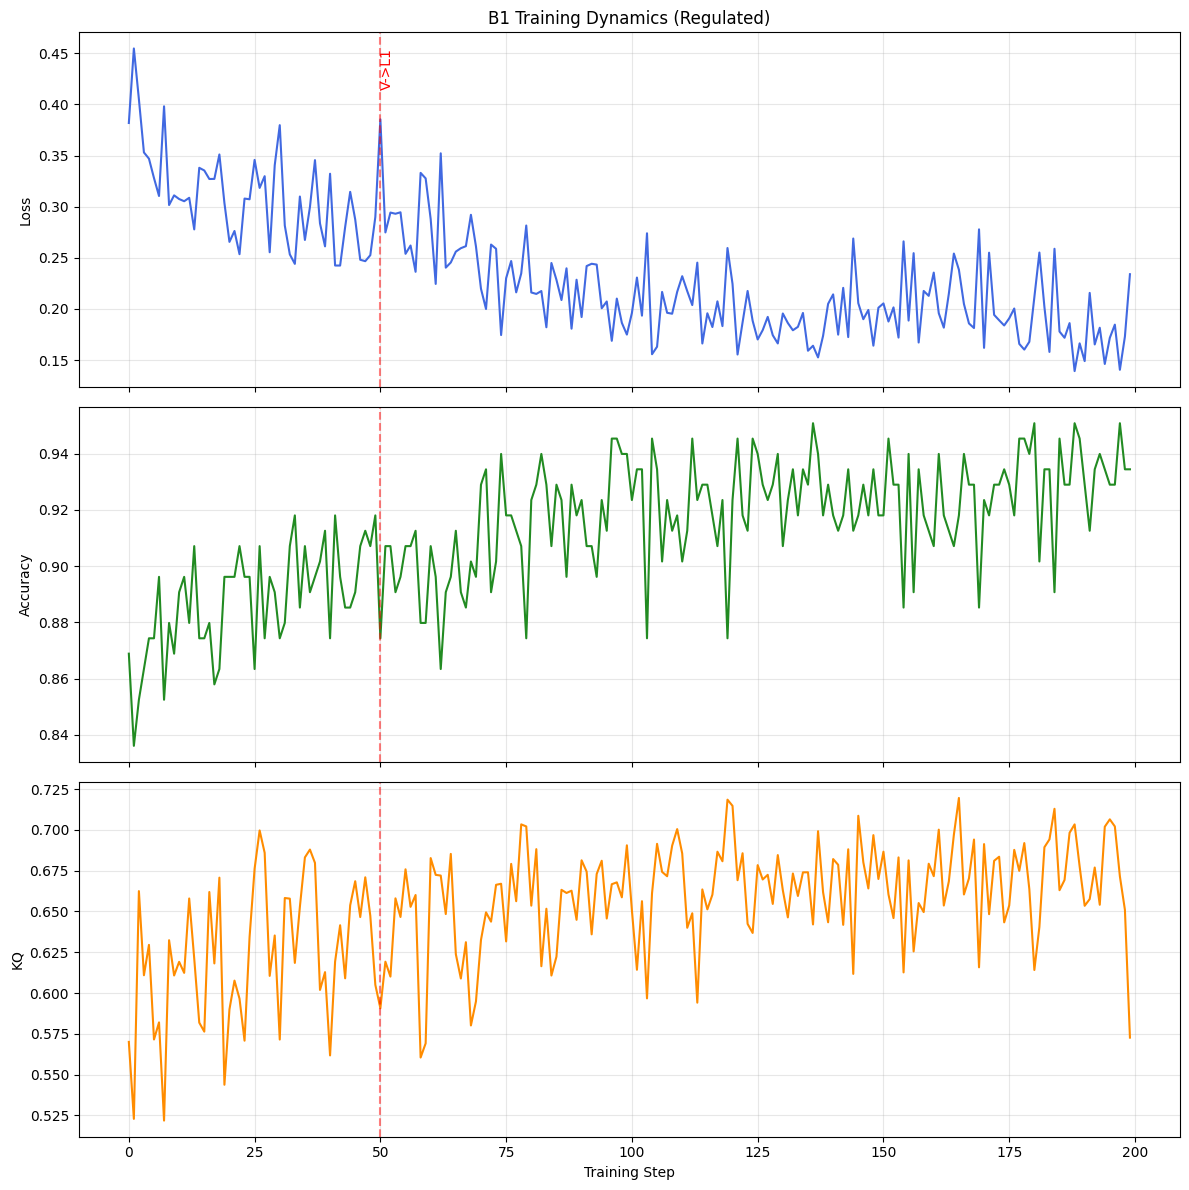

[AUDIT] Visualizations saved to /content/drive/MyDrive/SR-GNN_AUDIT/runs/srgnn_20251224T182721Z_75c8b21b/figures


In [17]:
# ============================================================
# Cell 17 — Audit Visualizations (B1 Training Dynamics)
# Purpose:
#    - Generate visual evidence for the audit report.
#    - Plot Loss, Accuracy, and KQ vs Steps.
#    - Highlight intervention points.
# ============================================================

import json
import matplotlib.pyplot as plt
from pathlib import Path

print("[AUDIT][Cell17] Generating visual evidence...")

METRICS_DIR = Path(RUN_ROOT) / "metrics"
FIG_DIR = Path(RUN_ROOT) / "figures"
m_path = METRICS_DIR / "regulated_run_metrics.json"

if not m_path.exists():
    print("[ERROR] No B1 metrics found. Run Cell 06 first.")
else:
    metrics = json.loads(m_path.read_text())
    steps = [m["step"] for m in metrics]
    loss = [m["loss"] for m in metrics]
    acc = [m.get("accuracy", 0) for m in metrics]
    kq = [m.get("KQ", 0) for m in metrics]
    status = [m.get("status", "OK") for m in metrics]

    fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

    # Plot 1: Loss
    axs[0].plot(steps, loss, label='Task Loss', color='royalblue')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('B1 Training Dynamics (Regulated)')
    axs[0].grid(True, alpha=0.3)

    # Plot 2: Accuracy
    axs[1].plot(steps, acc, label='Accuracy', color='forestgreen')
    axs[1].set_ylabel('Accuracy')
    axs[1].grid(True, alpha=0.3)

    # Plot 3: Quality (KQ)
    axs[2].plot(steps, kq, label='KQ (Quality)', color='darkorange')
    axs[2].set_ylabel('KQ')
    axs[2].set_xlabel('Training Step')
    axs[2].grid(True, alpha=0.3)

    # Mark Interventions
    for i, s in enumerate(status):
        if s not in ["OK", "COOLDOWN", "NONE"]:
            for ax in axs:
                ax.axvline(x=i, color='red', linestyle='--', alpha=0.5)
                if ax == axs[0]:
                    ax.text(i, max(loss), s, color='red', rotation=90, verticalalignment='top')

    plt.tight_layout()
    plt.savefig(FIG_DIR / "b1_training_dynamics.png")
    plt.show()

    print(f"[AUDIT] Visualizations saved to {FIG_DIR}")